In [1]:
######
# Here we plot the vertical radar profiles of different systems, depending on the morphology
######
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.radar import *
from src.pf_stats import *
from src.regions import *

In [2]:
#
# Choose regions to examine
#
regions = [sas_region()]

In [3]:
#
# Load radar data
#
radar = xr.concat(
    [load_merged_radar(r) for r in regions], 
    dim='features'
)

OSError: no files to open

In [6]:
#
# Load PF stats database
#
df = pd.concat(
    [load_pf_stats(r) for r in regions]
)

In [7]:
#
# Check that there is correspondance between stats and radar
#
assert(radar.features.size==df.shape[0])

In [24]:
#
# Separate extreme and typical features
#
MAXPR_THRESH = 5
MAXPR_EXTREME_THRESH = 80
MEANPR_EXTREME_THRESH = 10

# EXTREME: max precip
extreme_max_id = df['max_precip'] >= MAXPR_EXTREME_THRESH
extreme_max_df = df[extreme_max_id]
extreme_max_radar = radar.isel(features=np.where(extreme_max_id)[0])

# EXTREME: mean precip
extreme_mean_id = (df['total_precip'] / df['num_pixels']) >= MEANPR_EXTREME_THRESH
extreme_mean_df = df[extreme_mean_id]
extreme_mean_radar = radar.isel(features=np.where(extreme_mean_id)[0])

# TYPICAL: max precip within 25th–75th percentiles
typical_max_id = (
    (df['max_precip'] <= df['max_precip'].quantile(0.75)) &
    (df['max_precip'] >= df['max_precip'].quantile(0.25))
)
typical_max_df = df[typical_max_id]
typical_max_radar = radar.isel(features=np.where(typical_max_id)[0])

# TYPICAL: mean precip within 25th–75th percentiles
mean = df['total_precip'] / df['num_pixels']
typical_mean_id = (
    (mean <= mean.quantile(0.75)) &
    (mean >= mean.quantile(0.25))
)
typical_mean_df = df[typical_mean_id]
typical_mean_radar = radar.isel(features=np.where(typical_mean_id)[0])

In [25]:
# Assert that radar 'features' dimension matches DataFrame rows for 'extreme max'
assert extreme_max_radar.sizes['features'] == extreme_max_df.shape[0], (
    f"Mismatch in extreme_max_radar vs. extreme_max_df: "
    f"{extreme_max_radar.sizes['features']} vs. {extreme_max_df.shape[0]}"
)

# Assert that radar 'features' dimension matches DataFrame rows for 'extreme mean'
assert extreme_mean_radar.sizes['features'] == extreme_mean_df.shape[0], (
    f"Mismatch in extreme_mean_radar vs. extreme_mean_df: "
    f"{extreme_mean_radar.sizes['features']} vs. {extreme_mean_df.shape[0]}"
)

# Assert that radar 'features' dimension matches DataFrame rows for 'typical max'
assert typical_max_radar.sizes['features'] == typical_max_df.shape[0], (
    f"Mismatch in typical_max_radar vs. typical_max_df: "
    f"{typical_max_radar.sizes['features']} vs. {typical_max_df.shape[0]}"
)

# Assert that radar 'features' dimension matches DataFrame rows for 'typical mean'
assert typical_mean_radar.sizes['features'] == typical_mean_df.shape[0], (
    f"Mismatch in typical_mean_radar vs. typical_mean_df: "
    f"{typical_mean_radar.sizes['features']} vs. {typical_mean_df.shape[0]}"
)


In [46]:
panel_radar.min().compute()

<xarray.DataArray 'max_precip_refl' ()> Size: 8B
array(13.15999985)

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_60221/4249418201.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_2d = df_binned.groupby(["loc_bin", "area_bin"])["radar"].mean().unstack()
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_60221/4249418201.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_2d = df_binned.groupby(["loc_bin", "area_bin"])["radar"].mean().unstack()


Text(0.5, 1.05, 'Mean Radar Refl from 10km to 12km')

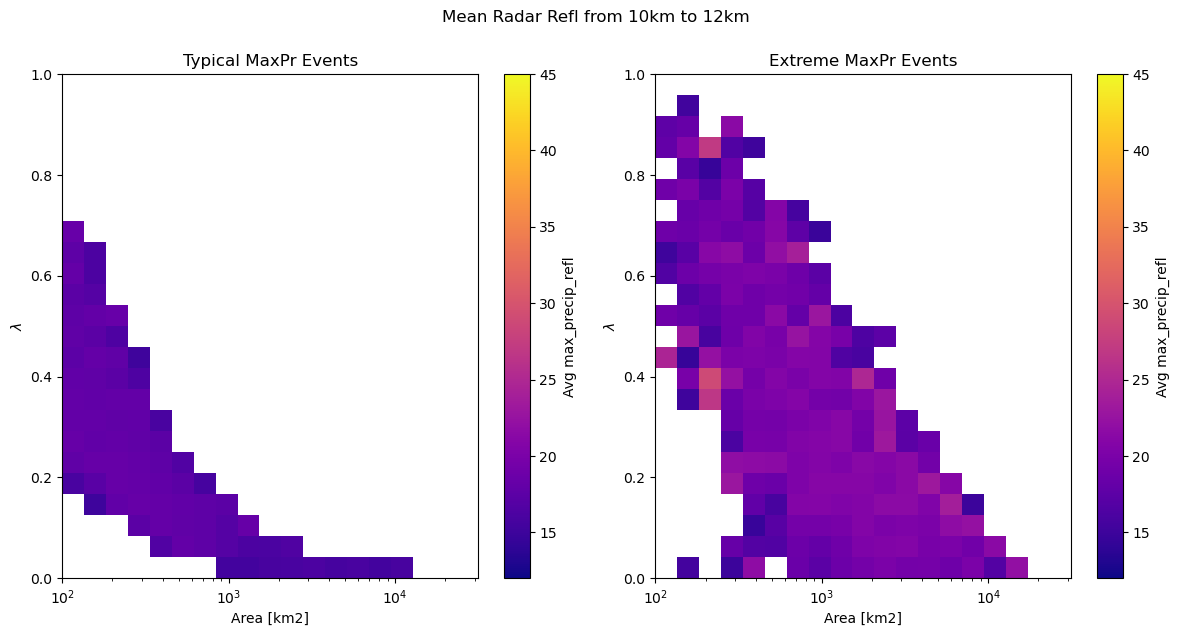

In [54]:
#######
# Plotting different levels
######

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
area_bins = np.logspace(2, 4.5, 20)
loc_bins = np.linspace(0, 1, 25)

low_alt, high_alt = 10, 12
alt_slice = slice(low_alt, high_alt)

#
# (0,0): First we look at the typical features
#
ax = axs[0]
panel_df = typical_max_df
panel_radar = typical_max_radar['max_precip_refl'].sel(alt=alt_slice).mean('alt')
panel_radar = np.log10(panel_radar) * 10

loc = panel_df['largest_5mmhr_cluster_max_precip_8conn']/panel_df['total_precip']
area = panel_df['num_pixels'] * 25


df_binned = pd.DataFrame({
    "area": panel_df['num_pixels'] * 25,  # or whatever area is
    "loc": panel_df['largest_5mmhr_cluster_max_precip_8conn'] / panel_df['total_precip'],
    "radar": panel_radar.values
})

# 2) Digitize area and loc into bins
df_binned["area_bin"] = pd.cut(df_binned["area"], bins=area_bins)
df_binned["loc_bin"] = pd.cut(df_binned["loc"], bins=loc_bins)

# 3) Group by those bins and compute the mean radar value
mean_2d = df_binned.groupby(["loc_bin", "area_bin"])["radar"].mean().unstack()

im = ax.pcolormesh(
    area_bins,
    loc_bins,
    mean_2d,
    norm=colors.Normalize(vmin=12, vmax=45),
    cmap=plt.cm.plasma
)
cb = plt.colorbar(im, ax=ax)
cb.set_label('Avg max_precip_refl')

# 5) Format the axes (log-scale on area)
ax.set_xscale('log')
ax.set_xlabel('Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('Typical MaxPr Events')


#
# (0,1): Now the extremes
#
ax = axs[1]
panel_df = extreme_max_df
panel_radar = extreme_max_radar['max_precip_refl'].sel(alt=alt_slice).mean('alt')
panel_radar = np.log10(panel_radar) * 10

loc = panel_df['largest_5mmhr_cluster_max_precip_8conn']/panel_df['total_precip']
area = panel_df['num_pixels'] * 25


df_binned = pd.DataFrame({
    "area": panel_df['num_pixels'] * 25,  # or whatever area is
    "loc": panel_df['largest_5mmhr_cluster_max_precip_8conn'] / panel_df['total_precip'],
    "radar": panel_radar.values
})

# 2) Digitize area and loc into bins
df_binned["area_bin"] = pd.cut(df_binned["area"], bins=area_bins)
df_binned["loc_bin"] = pd.cut(df_binned["loc"], bins=loc_bins)

# 3) Group by those bins and compute the mean radar value
mean_2d = df_binned.groupby(["loc_bin", "area_bin"])["radar"].mean().unstack()

im = ax.pcolormesh(
    area_bins,
    loc_bins,
    mean_2d,
    norm=colors.Normalize(vmin=12, vmax=45),
    cmap=plt.cm.plasma
)
cb = plt.colorbar(im, ax=ax)
cb.set_label('Avg max_precip_refl')

# 5) Format the axes (log-scale on area)
ax.set_xscale('log')
ax.set_xlabel('Area [km2]')
ax.set_ylabel(r'$\lambda$')
ax.set_title('Extreme MaxPr Events')


fig.tight_layout(pad=1)
fig.suptitle(f'Mean Radar Refl from {low_alt}km to {high_alt}km', y=1.05)

In [34]:
panel_radar.values

array([3000.97072841,  689.81119282,  807.92470941, ...,  649.29800937,
       1543.61314631, 2004.18582964])

In [17]:
radar.isel(features=np.where(extreme_max_id)[0])

<xarray.Dataset> Size: 77MB
Dimensions:                           (features: 13095, alt: 176)
Coordinates:
    time                              (features) datetime64[ns] 105kB dask.array<chunksize=(6417,), meta=np.ndarray>
  * alt                               (alt) float32 704B 0.0 0.125 ... 21.88
  * features                          (features) <U68 4MB 'pf_0124.GPM2Ku7_uw...
Data variables:
    mean_refl                         (features, alt) float64 18MB dask.array<chunksize=(6417, 176), meta=np.ndarray>
    largest_5mmhr_cluster_refl_conn8  (features, alt) float64 18MB dask.array<chunksize=(6417, 176), meta=np.ndarray>
    largest_5mmhr_cluster_refl_conn4  (features, alt) float64 18MB dask.array<chunksize=(6417, 176), meta=np.ndarray>
    max_precip_refl                   (features, alt) float64 18MB dask.array<chunksize=(6417, 176), meta=np.ndarray>

In [13]:
extreme_mean_radar = radar
extreme_mean_radar


<xarray.Dataset> Size: 8GB
Dimensions:                           (features: 1437514, alt: 176)
Coordinates:
    time                              (features) datetime64[ns] 12MB dask.array<chunksize=(5476,), meta=np.ndarray>
  * alt                               (alt) float32 704B 0.0 0.125 ... 21.88
  * features                          (features) <U68 391MB 'pf_0001.GPM2Ku7_...
Data variables:
    mean_refl                         (features, alt) float64 2GB dask.array<chunksize=(5476, 176), meta=np.ndarray>
    largest_5mmhr_cluster_refl_conn8  (features, alt) float64 2GB dask.array<chunksize=(5476, 176), meta=np.ndarray>
    largest_5mmhr_cluster_refl_conn4  (features, alt) float64 2GB dask.array<chunksize=(5476, 176), meta=np.ndarray>
    max_precip_refl                   (features, alt) float64 2GB dask.array<chunksize=(5476, 176), meta=np.ndarray>

In [12]:
extreme_mean_df

,gpm_filename,feature_id,observation_time,mean_latitude,mean_longitude,precipitation_centroid_latitude,precipitation_centoid_longitude,num_pixels,num_convective_pixels,num_stratiform_pixels,...,largest_10mmhr_cluster_size_8conn,largest_10mmhr_cluster_precip_8conn,largest_10mmhr_cluster_max_precip_8conn,num_20mmhr_pixels,largest_20mmhr_cluster_size_4conn,largest_20mmhr_cluster_precip_4conn,largest_20mmhr_cluster_max_precip_4conn,largest_20mmhr_cluster_size_8conn,largest_20mmhr_cluster_precip_8conn,largest_20mmhr_cluster_max_precip_8conn
102,/home/disk/archive3/gpm/v07/CIO/interp_data/20...,58,20150102_04:49:00,-0.490000,96.820000,-0.492320,96.839447,5,2,3,...,1,34.607258,34.607258,1,1,34.607258,34.607258,1,34.607258,34.607258
143,/home/disk/archive3/gpm/v07/CIO/interp_data/20...,92,20150102_06:22:24,-2.750000,74.362495,-2.772596,74.363383,12,8,4,...,2,38.604650,20.073734,3,1,20.073734,20.073734,1,20.073734,20.073734
383,/home/disk/archive3/gpm/v07/CIO/interp_data/20...,124,20150103_18:33:04,-5.201786,60.310711,-5.247384,60.302134,28,13,15,...,7,229.331012,98.560020,3,3,179.398327,98.560020,3,179.398327,98.560020
518,/home/disk/archive3/gpm/v07/CIO/interp_data/20...,163,20150104_17:36:46,-8.075000,67.074997,-8.090116,67.075611,4,3,1,...,2,32.822645,16.474493,0,0,0.000000,NaN,0,0.000000,NaN
749,/home/disk/archive3/gpm/v07/CIO/interp_data/20...,50,20150106_15:57:18,-5.635294,87.485291,-5.604440,87.503483,17,10,7,...,4,168.216856,70.560806,3,3,153.180897,70.560806,3,153.180897,70.560806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881592,/home/disk/archive3/gpm/v07/WMP/interp_data/20...,6,20241230_14:00:09,-1.150000,164.675003,-1.154259,164.654639,4,4,0,...,1,44.828873,44.828873,1,1,44.828873,44.828873,1,44.828873,44.828873
881625,/home/disk/archive3/gpm/v07/WMP/interp_data/20...,22,20241230_14:03:51,-13.349999,171.125000,-13.350602,171.148149,4,0,4,...,1,95.346512,95.346512,1,1,95.346512,95.346512,1,95.346512,95.346512
881811,/home/disk/archive3/gpm/v07/WMP/interp_data/20...,185,20241231_04:41:43,-1.612500,121.199997,-1.610098,121.194149,4,4,0,...,1,28.332504,28.332504,1,1,28.332504,28.332504,1,28.332504,28.332504
881898,/home/disk/archive3/gpm/v07/WMP/interp_data/20...,13,20241231_14:51:43,-26.387499,157.899994,-26.396271,157.862036,4,2,2,...,1,38.882446,38.882446,1,1,38.882446,38.882446,1,38.882446,38.882446


In [ ]:

stats = load_pf_stats(region, trim_region=True)
assert(radar.features.size==stats.shape[0])

#
# We want to see how the vertical structure of more localized systems look
#

extreme_id = stats['max_precip'] >= 0
radar = radar.isel(features=extreme_id)
stats = stats[extreme_id]


loc = stats['largest_5mmhr_cluster_max_precip_8conn'] / stats['total_precip']
loc_da = xr.DataArray(
    data=loc.values,
    dims=["features"],
    coords={"features": radar.features},
    name="loc"
)
Z = np.log10(radar['max_precip_refl']) * 10


In [ ]:
#
# Attach loc_da to Z as a coordinate named "loc"
#
Z_with_loc = Z.assign_coords(loc=loc_da)

#
# Define bins from 0 to 1 in 10 equal steps
#
bins = np.linspace(0, 1, 20)

#
# Group by "loc" bins, then compute the mean across 'features'
#
Z_binned = Z_with_loc.groupby_bins('loc', bins=bins).mean(dim='features')

#
# Now we can contour or contourf.
# Suppose Z has dimensions like (features, height) or (features, z).
# After groupby_bins, "features" is reduced, so you’re left with something like
# ('loc_bins', 'height').
#
fig, ax = plt.subplots(figsize=(6, 5))

# If your vertical dimension is called "height", try this:
# (If it’s named something else like 'z' or 'alt', use that name here.)
Z_binned.plot.contourf(x='loc_bins', y='alt', ax=ax, levels=20, cmap='turbo')

ax.set_title('Average Reflectivity Profiles by Localization Bin')
ax.set_xlabel('Localization (loc) bins')
ax.set_ylabel('Height (km)')  # or whatever your units are
plt.show()
